# Planar flow

In [49]:
# Import required packages
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

In [50]:
K = 16
#torch.manual_seed(0)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

flows = []
for i in range(K):
    flows += [nf.flows.Planar((1,))]
    flows += [nf.flows.Radial((1, ))]
target = nf.distributions.TwoModes(0.5, 0.2)

q0 = nf.distributions.DiagGaussian(1)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0-13): 14 x AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): MLP(
            (net): Sequential(
              (0): Linear(in_features=1, out_features=64, bias=True)
              (1): LeakyReLU(negative_slope=0.0)
              (2): Linear(in_features=64, out_features=1, bias=True)
            )
          )
        )
        (2): Merge()
      )
    )
  )
)

In [48]:
# Plot target distribution
grid_size = 200
z = torch.linspace(-3, 3, grid_size).unsqueeze(1)
log_prob = target.log_prob(z)#.view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(10, 10))
plt.plot(z, prob)
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

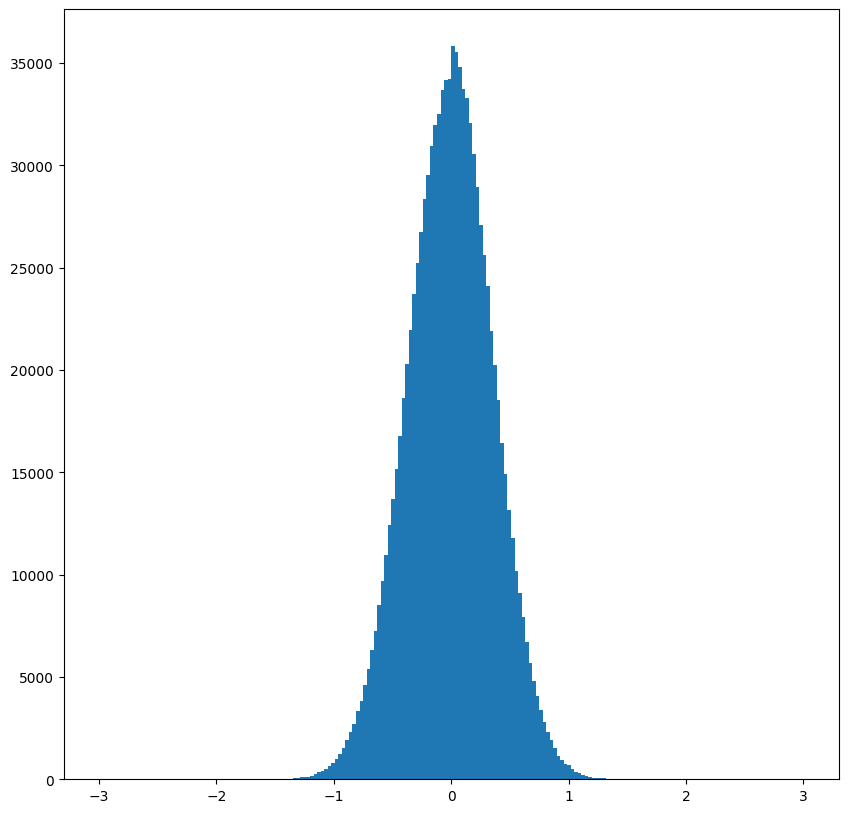

In [30]:
# Plot initial flow distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist(z_np, bins=grid_size, range=[-3, 3])
plt.show()

100%|██████████| 1000/1000 [00:02<00:00, 366.23it/s]


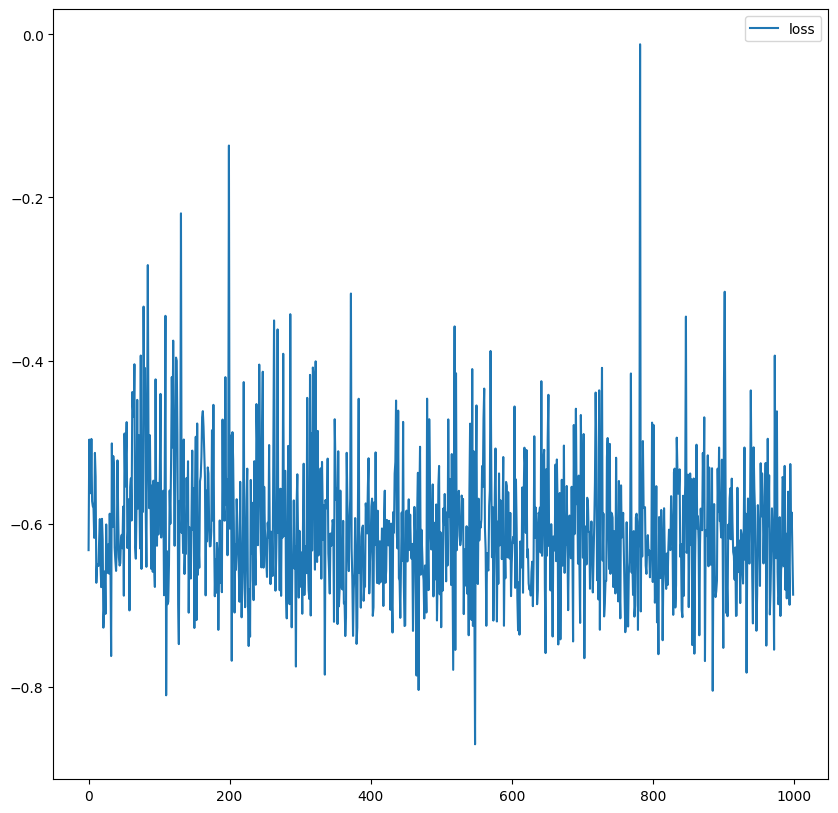

In [31]:
# Train model
max_iter = 1000
num_samples = 2 * 20
anneal_iter = 1000
annealing = False
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-2, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = nfm.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # # Plot learned distribution
    # if (it + 1) % show_iter == 0:
    #     torch.cuda.manual_seed(0)
    #     z, _ = nfm.sample(num_samples=2 ** 20)
    #     z_np = z.to('cpu').data.numpy()
        
        # plt.figure(figsize=(10, 10))
        # plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        # plt.show()

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

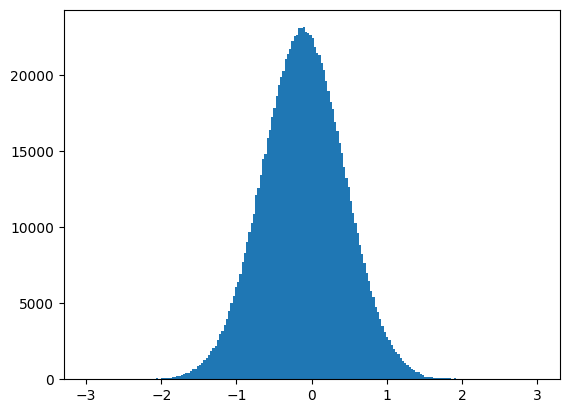

In [32]:
# Plot learned distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure()
plt.hist(z_np, bins=grid_size, range=[-3, 3])
plt.show()

tensor([-0.8047, -3.0969, -0.8320,  ..., -0.6145, -1.5270, -0.6769],
       grad_fn=<AddBackward0>)
